

## Callbacks in Keras

# IMDb Example

Let's apply the EarlyStopping and ModelCheckpoint callbacks to the IMDb example to (1) stop the training process when validation performance is not improving for certain number of training epochs, and (2) automatically save the best model, i.e., the model with the lowest validation loss.
This can save us on the time and computational resources needed to train the expensive RNN models.


Let's start by preparing the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after 100 words, or pad them to length 100, using the `pad_sequences` function below.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Load the data as lists of integers
# We only keep the top 10,000 most frequently occurring words in the training data
# (Rare words will be discarded as before)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# IMPORTANT NOTE: The IMDb data are already tokenized (i.e., each review is
# already converted to a list of integers. So, we skip the Tokenization step
# and move directly to the padding step below.

# Recall that our movie reviews have different lengths.
# The following turns our lists of integers into a 2D integer tensor of shape `(samples, maxlen=100)`
# In other words, for reviews shorter than 100 words, we add zeros to make the length=100;
# for reviews longer than 100 words, we cut them after 100 words. (100 is arbitrary!)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=100)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=100)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(25000, 100)

In [ ]:
x_test.shape

(25000, 100)

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:

In [ ]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## A SimpleRNN Model

We'll first develop a model with a `SimpleRNN` layer with 64 units. We use an `Embedding` layer to obtain word embeddings, then we feed them into our RNN layer.
Recall the the size of our vocabulary is 10,000 and the length of each input sample (review) is 100 words. In here, 128 is the dimension for the word embeddings (each word will be converted into a vector with 128 numbers). 128 is a hyperparameter.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model1 = models.Sequential()

model1.add(layers.Embedding(10000, 128, input_length=100))

model1.add(layers.SimpleRNN(64))

# The output unit must have 'sigmoid' activation since this is a binary classification
model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model1_history = model1.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 8s 116ms/step - loss: 0.6807 - accuracy: 0.5622 - val_loss: 0.6580 - val_accuracy: 0.6082
Epoch 2/20
30/30 [==============================] - 3s 105ms/step - loss: 0.5253 - accuracy: 0.7825 - val_loss: 0.5979 - val_accuracy: 0.6733
Epoch 3/20
30/30 [==============================] - 3s 111ms/step - loss: 0.2951 - accuracy: 0.9105 - val_loss: 0.5172 - val_accuracy: 0.7704
Epoch 4/20
30/30 [==============================] - 3s 110ms/step - loss: 0.1515 - accuracy: 0.9635 - val_loss: 0.4707 - val_accuracy: 0.7891
Epoch 5/20
30/30 [==============================] - 3s 112ms/step - loss: 0.0918 - accuracy: 0.9752 - val_loss: 0.5510 - val_accuracy: 0.7576
Epoch 6/20
30/30 [==============================] - 3s 109ms/step - loss: 0.0299 - accuracy: 0.9981 - val_loss: 0.5870 - val_accuracy: 0.7757
Epoch 7/20
30/30 [==============================] - 3s 107ms/step - loss: 0.0152 - accuracy: 0.9987 - val_loss: 0.8491 - val_accuracy: 0.6755
Epoch 

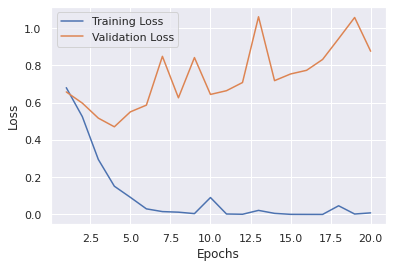

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc1  = model1_history.history['accuracy']
train_loss1 = model1_history.history['loss']
val_acc1  = model1_history.history['val_accuracy']
val_loss1 = model1_history.history['val_loss']

epochs = range(1, len(train_acc1) + 1)

plt.plot(epochs, train_loss1, label = 'Training Loss')
plt.plot(epochs, val_loss1, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

We can see that the model overfits after 4 epochs. So, ideally, we should stop training early and save the model at the end of epoch 4 as our best performing model. We will do so next using `Callbacks`.

In [ ]:
# Evaluate the model on the test set
model1.evaluate(x_test, y_test)

782/782 [==============================] - 8s 10ms/step - loss: 0.8705 - accuracy: 0.7741


[0.8705066442489624, 0.7741199731826782]

The simple RNN model achieves 77.4% accuracy on the test data.

## Adding Callbacks to the SimpleRNN Model

In [ ]:
model1_cb = models.Sequential()

model1_cb.add(layers.Embedding(10000, 128, input_length=100))

model1_cb.add(layers.SimpleRNN(64))

# The output unit must have 'sigmoid' activation since this is a binary classification
model1_cb.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model1_cb.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

Below, I am creating a callbacks list to stop the training process if the validation accuracy has not improved for 2 epochs. I also save the best model, i.e., the model with the lowest validation loss.

In [ ]:
from tensorflow.keras import callbacks

callbacks_list = [
    callbacks.EarlyStopping(monitor="val_accuracy", patience=3),
    callbacks.ModelCheckpoint(filepath="checkpoint_model1.keras",
                                    monitor="val_loss", save_best_only=True)
    ]

In [ ]:
model1_cb_history = model1_cb.fit(partial_x_train,
                                  partial_y_train,
                                  epochs=20,
                                  batch_size=512,
                                  callbacks=callbacks_list,
                                  validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 5s 124ms/step - loss: 0.6887 - accuracy: 0.5631 - val_loss: 0.6635 - val_accuracy: 0.5970
Epoch 2/20
30/30 [==============================] - 3s 112ms/step - loss: 0.5367 - accuracy: 0.7743 - val_loss: 0.5598 - val_accuracy: 0.7092
Epoch 3/20
30/30 [==============================] - 3s 113ms/step - loss: 0.3480 - accuracy: 0.8733 - val_loss: 0.5061 - val_accuracy: 0.7534
Epoch 4/20
30/30 [==============================] - 4s 119ms/step - loss: 0.2136 - accuracy: 0.9355 - val_loss: 0.4400 - val_accuracy: 0.8137
Epoch 5/20
30/30 [==============================] - 3s 114ms/step - loss: 0.1249 - accuracy: 0.9665 - val_loss: 0.6551 - val_accuracy: 0.6780
Epoch 6/20
30/30 [==============================] - 3s 111ms/step - loss: 0.0647 - accuracy: 0.9889 - val_loss: 0.6716 - val_accuracy: 0.7328
Epoch 7/20
30/30 [==============================] - 3s 110ms/step - loss: 0.0428 - accuracy: 0.9915 - val_loss: 0.5665 - val_accuracy: 0.8126


The training process stoped after 7 epochs because for 3 consecutive epochs (i.e., epochs 5, 6, and 7) the validation loss did not improve.

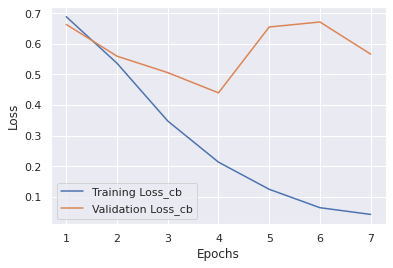

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc1_cb  = model1_cb_history.history['accuracy']
train_loss1_cb = model1_cb_history.history['loss']
val_acc1_cb  = model1_cb_history.history['val_accuracy']
val_loss1_cb = model1_cb_history.history['val_loss']

epochs = range(1, len(train_acc1_cb) + 1)

plt.plot(epochs, train_loss1_cb, label = 'Training Loss_cb')
plt.plot(epochs, val_loss1_cb, label = 'Validation Loss_cb')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

To load the model we’ve saved (i.e., the model at the end of epoch 4), we can use the following code.

In [ ]:
model1_cb_best = models.load_model("checkpoint_model1.keras")

In [ ]:
# Evaluate the saved model (after 4 epochs) on the test set
model1_cb_best.evaluate(x_test, y_test)

782/782 [==============================] - 8s 10ms/step - loss: 0.4299 - accuracy: 0.8164


[0.4298762083053589, 0.8163599967956543]

In [ ]:
# Evaluate the last model (after 7 epochs) on the test set
model1_cb.evaluate(x_test, y_test)

782/782 [==============================] - 8s 10ms/step - loss: 0.5733 - accuracy: 0.8057


[0.573310911655426, 0.8057199716567993]

We can see that the model after 4 training epochs performs better on the test data than the latest model after 7 training epochs.

## An LSTM Model with Recurrent Dropout and Callbacks

In [ ]:
model2 = models.Sequential()

model2.add(layers.Embedding(input_dim=10000, output_dim=128, input_length=100))

model2.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model2.add(layers.Dense(50, activation='relu'))

model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

Below, I am creating a callbacks list to stop the training process if the validation loss has not improved for 4 epochs. I also save the best model, i.e., the model with the lowest validation loss.

In [ ]:
from tensorflow.keras import callbacks

callbacks_list = [
    callbacks.EarlyStopping(monitor="val_loss", patience=4),
    callbacks.ModelCheckpoint(filepath="checkpoint_model2.keras",
                              monitor="val_loss", save_best_only=True)
    ]

In [ ]:
model2_history = model2.fit(partial_x_train,
                            partial_y_train,
                            epochs=50,
                            batch_size=512,
                            callbacks=callbacks_list,
                            validation_data=(x_val, y_val))

Epoch 1/50
30/30 [==============================] - 17s 490ms/step - loss: 0.6941 - accuracy: 0.6623 - val_loss: 0.4871 - val_accuracy: 0.7863
Epoch 2/50
30/30 [==============================] - 14s 468ms/step - loss: 0.4322 - accuracy: 0.8169 - val_loss: 0.5185 - val_accuracy: 0.7800
Epoch 3/50
30/30 [==============================] - 14s 471ms/step - loss: 0.3318 - accuracy: 0.8665 - val_loss: 0.4375 - val_accuracy: 0.7915
Epoch 4/50
30/30 [==============================] - 14s 469ms/step - loss: 0.2801 - accuracy: 0.8869 - val_loss: 0.4438 - val_accuracy: 0.8351
Epoch 5/50
30/30 [==============================] - 14s 462ms/step - loss: 0.2400 - accuracy: 0.9053 - val_loss: 0.4362 - val_accuracy: 0.8330
Epoch 6/50
30/30 [==============================] - 14s 456ms/step - loss: 0.1987 - accuracy: 0.9237 - val_loss: 0.4566 - val_accuracy: 0.8372
Epoch 7/50
30/30 [==============================] - 14s 472ms/step - loss: 0.1959 - accuracy: 0.9233 - val_loss: 0.3902 - val_accuracy: 0.8441

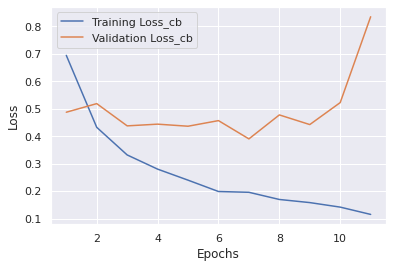

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc2  = model2_history.history['accuracy']
train_loss2 = model2_history.history['loss']
val_acc2  = model2_history.history['val_accuracy']
val_loss2 = model2_history.history['val_loss']

epochs = range(1, len(train_acc2) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss_cb')
plt.plot(epochs, val_loss2, label = 'Validation Loss_cb')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Now, let's evaluate our best model on the test data. We first need to load it.

In [ ]:
model2_best = models.load_model("checkpoint_model2.keras")

In [ ]:
# Evaluate the model on the test set
model2_best.evaluate(x_test, y_test)

782/782 [==============================] - 25s 31ms/step - loss: 0.3914 - accuracy: 0.8412


[0.3914257884025574, 0.8412399888038635]

We see that using LSTM, recurrent dropout, and automatic early stopping via the callback method, we achieved 84.1% accuracy on the test dataset.